In [1]:
import pandas as pd
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df = pd.read_csv('bike_demand.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
df['date'] = pd.to_datetime(df['datetime']).dt.date
df_mean = df.groupby('date')[['atemp', 'humidity']].mean()
df_sum = df.groupby('date')['count'].sum()

df_by_day = df_mean.merge(df_sum, left_index=True, right_index=True)
df_by_day["date"] = df_by_day.index
df_by_day = df_by_day.reset_index(drop=True)
df_by_day = df_by_day.rename(columns={'date':'ds', 'count':'y'})
df_by_day

,atemp,humidity,y,ds
0,18.181250,80.583333,985,2011-01-01
1,17.686957,69.608696,801,2011-01-02
2,9.470227,43.727273,1349,2011-01-03
3,10.606087,59.043478,1562,2011-01-04
4,11.463478,43.695652,1600,2011-01-05
...,...,...,...,...
451,16.919167,65.041667,5047,2012-12-15
452,18.496875,83.875000,3786,2012-12-16
453,20.075000,90.708333,4585,2012-12-17
454,20.485417,66.625000,5557,2012-12-18


14:13:16 - cmdstanpy - INFO - Chain [1] start processing
14:13:16 - cmdstanpy - INFO - Chain [1] done processing


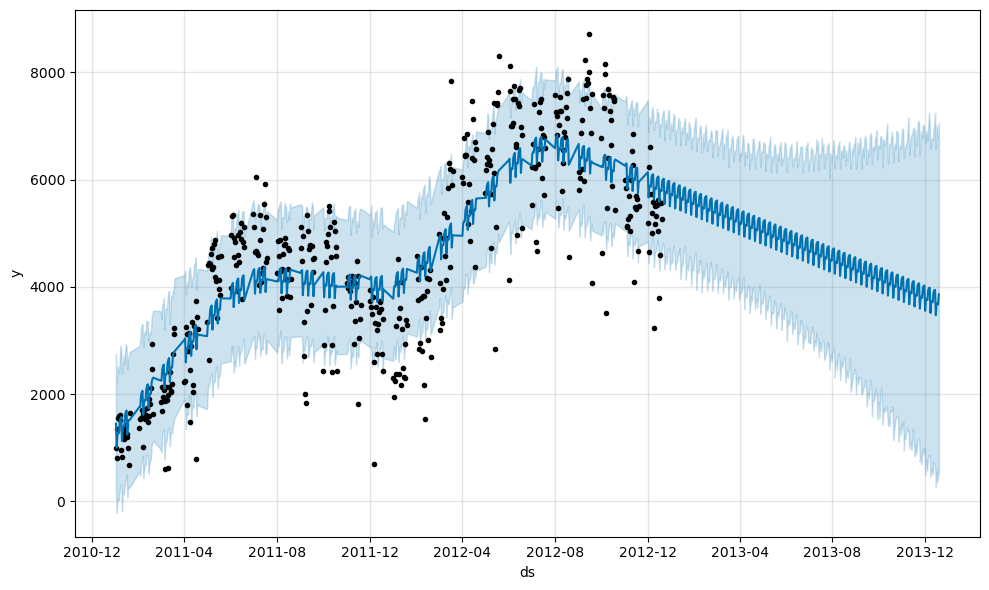

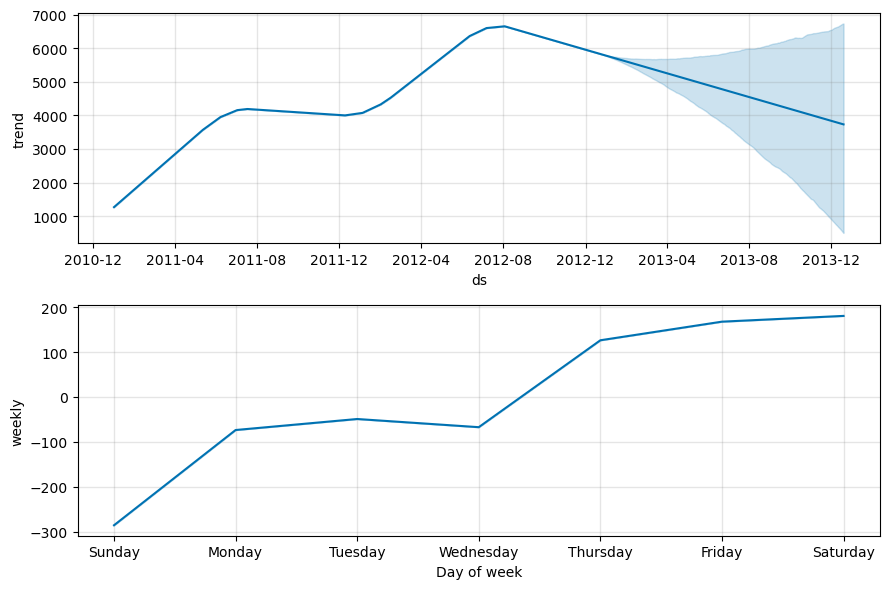

In [4]:
m = Prophet()
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [7]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '30 days')

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

  0%|          | 0/47 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.660067e+06,1288.435715,942.987443,0.182179,0.112592,0.184690,0.634958
1,4 days,1.445228e+06,1202.176514,897.608739,0.166751,0.086002,0.172586,0.621839
2,5 days,1.828134e+06,1352.085048,1044.007466,0.187189,0.146009,0.189794,0.570634
3,6 days,2.286780e+06,1512.210378,1188.047451,0.231199,0.189198,0.218386,0.533888
4,7 days,2.513563e+06,1585.421943,1266.596816,0.255047,0.211230,0.236904,0.523187


In [11]:
m = Prophet()
m.add_regressor('atemp')
m.add_regressor('humidity')

m.fit(df_by_day)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '30 days')

df_p = performance_metrics(df_cv)
df_p.head()

  0%|          | 0/47 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,7.038838e+05,838.977842,687.524565,0.121578,0.106087,0.120355,0.724534
1,4 days,7.839010e+05,885.381814,696.305390,0.118877,0.098954,0.118326,0.758621
2,5 days,1.088304e+06,1043.217985,771.447386,0.131906,0.098954,0.129014,0.750834
3,6 days,1.455288e+06,1206.353344,912.741387,0.172134,0.116836,0.160200,0.680935
4,7 days,1.374199e+06,1172.262159,864.133324,0.172878,0.114283,0.157295,0.705113


In [16]:
m = Prophet()
m.add_regressor('atemp')
m.add_regressor('humidity')
m.add_seasonality(name='yearly', period=364, fourier_order=10)

m.fit(df_by_day)
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '30 days')

df_p = performance_metrics(df_cv)
print(df_p['mae'].mean())

  0%|          | 0/47 [00:00<?, ?it/s]

  horizon           mse         rmse         mae      mape     mdape  \
0  3 days  7.965479e+05   892.495294  762.073175  0.138408  0.119179   
1  4 days  8.426422e+05   917.955452  785.723997  0.137508  0.117176   
2  5 days  1.060177e+06  1029.648813  820.853928  0.143646  0.113652   
3  6 days  1.302623e+06  1141.325057  901.512180  0.171892  0.126653   
4  7 days  1.261322e+06  1123.085969  842.355431  0.173308  0.128934   

      smape  coverage  
0  0.142069  0.540626  
1  0.144003  0.504598  
2  0.149228  0.560623  
3  0.167687  0.499802  
4  0.162823  0.568371  
831.7649683340778
